# Objectif phase Modelisation

L'objectif de cette phase est de modeliser les phénomènes demandés à partir de datas declaratives afin d'eviter les couteuses mesures permettant l'établissement d'un EnergyStarScore: 

- Emission CO2
- GHGE total emission

Pour cela nous utiliserons des regressions mais pas que afin de modeliser au mieux ces phénomènes.

### La mesure de performance des modèles sera faite par: 

- RMSE
- MAPE 

#### Un des enjeux de cette phase et aussi l'interpretabilité des predictions et du features weights des predictions. 

### Enfin nous concluerons sur le meilleur modèle et la capacité à se passer des couteuses mesures pour evaluer  les emissions des batiments en CO2 et leur consommation GHGE. 

### Etape 1 - Chargement des librairies nécessaires.  

In [119]:
import time
import pandas as pd 
import numpy as np
import eli5
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model, model_selection, metrics, svm, neural_network
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.kernel_ridge import KernelRidge

### Etape 2 - Chargement des dataframes exportés à l'étape precedente. 

In [120]:
filteredDF = pd.read_csv("filteredDF.csv", decimal=".", delimiter=",")
#shape 6805 lignes et 38 colonnes
filteredDF.columns

Index(['Unnamed: 0', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'totalKbtu', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'City', 'State', 'Location',
       'PrimaryPropertyType', 'PropertyGFAParking', 'Neighborhood',
       'NeighborhoodInt', 'BuildingType', 'BuildingTypeInt',
       'ENERGYSTARScoreColor', 'TotalGHGEmissions'],
      dtype='object')

In [121]:
#filteredDF["PropertyGFAParking"]  = filteredDF["PropertyGFAParking"].astype(str)
filteredDF["PrimaryPropertyType"]  = filteredDF["PrimaryPropertyType"].astype(str)
#filteredDF["ListOfAllPropertyUseTypes"] = filteredDF["ListOfAllPropertyUseTypes"].astype(str)
#filteredDF["PropertyGFAParking"] = filteredDF["PropertyGFAParking"].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], "autre")
filteredDF.shape

(6716, 30)

In [122]:
a = filteredDF["PrimaryPropertyType"].value_counts().to_frame()
a = a[a["PrimaryPropertyType"] > 1]
print(sum(a.values))
a
# faible nombre d'instances eventuellement à oublier. 

[6716]


,PrimaryPropertyType
low-rise multifamily,1985
mid-rise multifamily,1103
small- and mid-sized office,590
other,514
large office,344
k-12 school,275
mixed use property,259
high-rise multifamily,208
retail store,191
non-refrigerated warehouse,187


In [123]:
nonNullRateFrame = pd.read_csv("nonNullFrame.csv", decimal=".", delimiter=",")
nonNullRateFrame

,Unnamed: 0,columns,type,filledRatio,nbValues
0,0,OSEBuildingID,int64,100.000,3432
1,1,DataYear,int64,100.000,2
2,2,BuildingType,object,100.000,8
3,3,PrimaryPropertyType,object,100.000,29
4,4,PropertyName,object,100.000,6527
5,5,TaxParcelIdentificationNumber,object,99.970,3729
6,6,Location,object,49.732,3298
7,7,CouncilDistrictCode,int64,100.000,7
8,8,Neighborhood,object,100.000,13
9,9,YearBuilt,int64,100.000,113


Traitement de YearBuilt et BuildingTypeInt et transformation de ces variables en numerics

In [124]:
# Energy Variables
#for y let's keep only rows with data
#filteredDF2['GHGEmissions(MetricTonsCO2e)'] = filteredDF2['GHGEmissions(MetricTonsCO2e)'].replace(np.nan, -1000)
#filteredDF2 = filteredDF2[filteredDF2['GHGEmissions(MetricTonsCO2e)'] > 0]
filteredDF2 = filteredDF2[filteredDF2['GHGEmissionsIntensity(kgCO2e/ft2)'] > -1000]
filteredDF2 = filteredDF2[filteredDF2['LargestPropertyUseTypeGFA'] > -1000]
filteredDF2 = filteredDF2[filteredDF2['PropertyGFATotal'] > -1000]


#filteredDF2['YearBuilt'] = filteredDF2['YearBuilt'].replace(np.nan, -1000)
#print(np.unique(filteredDF2['GHGEmissionsIntensity(kgCO2e/ft2)'].values))
#nonNullRateFrame.columns.str.contains("kbtu")
kbtusColumns = nonNullRateFrame[nonNullRateFrame["columns"].str.contains("kBtu")]
CO2Columns = nonNullRateFrame[nonNullRateFrame["columns"].str.contains("CO2")]
kwhColumns = nonNullRateFrame[nonNullRateFrame["columns"].str.contains("kWh")]
listToChange = list(kwhColumns['columns'].values) + list(CO2Columns['columns'].values) + list(kbtusColumns['columns'].values)
noEnergyList = []

toTrash = ['Unnamed: 0', 
           #"ListOfAllPropertyUseTypes", 
           "Location", 
           "State", 
           "ThirdLargestPropertyUseType", 
           "PropertyGFAParking", 
           "Neighborhood", 
           "PrimaryPropertyType", 
           "NaturalGas(therms)", 
           "YearsENERGYSTARCertified", 
           "ENERGYSTARScore", 
           "ENERGYSTARScoreColor", 
           "TotalGHGEmissions", 
           "City", 
           #"YearBuilt", 
           "Address", 
           "GHGEmissionsIntensity"]
toTrash = toTrash + [
        'NumberofBuildings', 
       'PropertyGFABuilding(s)', 
        'LargestPropertyUseType', 
        "LargestPropertyUseTypeGFA",
        #"PropertyGFATotal", 
        "BuildingType", 
        "totalKbtu", 
       "NumberofFloors", 
       'ThirdLargestPropertyUseTypeGFA']


for column in filteredDF2.columns:
    if column not in listToChange and column not in toTrash:
        noEnergyList.append(column)

print("noEnergyList", noEnergyList)
#print("frameShape", filteredDF2.shape)

noEnergyList ['YearBuilt', 'PropertyGFATotal', 'NeighborhoodInt', 'BuildingTypeInt', 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc', 'LargestPropertyUseTypeEnc', 'LocationEnc', 'PropertyGFAParkingEnc', 'NumberofFloorsEnc', 'NumberofBuildingsEnc']


# Filtres des Datas pour le modelisation de GHGEmissions(MetricTonsCO2e)

In [125]:
filteredDF2 = filteredDF 
filteredDF2['GHGEmissions(MetricTonsCO2e)'] = filteredDF2['GHGEmissions(MetricTonsCO2e)'].replace(np.nan, -1000)
filteredDF2 = filteredDF2[filteredDF2['GHGEmissions(MetricTonsCO2e)'] >= 0]

# Avec label encoder pour les variables categorielles suivantes: 
- Neighborhood
- PrimaryPropertyType
- BuildingType
- LargestPropertyUseType
- Location
- PropertyGFAParking
- NumberofFloors
- NumberofBuildings

<ipython-input-126-35a91ad9cc54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredDF2[newCol] = encoder.fit_transform(filteredDF2[column].values)
<ipython-input-126-35a91ad9cc54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredDF2[newCol] = encoder.fit_transform(filteredDF2[column].values)
<ipython-input-126-35a91ad9cc54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

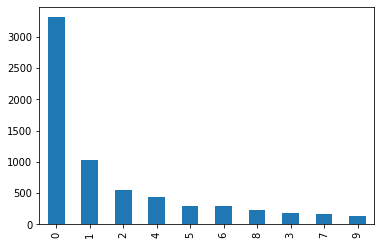

In [126]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
encoder = LabelEncoder()
for column in ["Neighborhood", "PrimaryPropertyType", "BuildingType", "LargestPropertyUseType","Location", "PropertyGFAParking", "NumberofFloors", "NumberofBuildings"]:
    newCol = column+"Enc"
    filteredDF2[newCol] = encoder.fit_transform(filteredDF2[column].values)
    filteredDF2[newCol].value_counts().plot(kind="bar")
#filteredDF2["BuildingTypeEnc"].value_counts().plot(kind="bar")


# Variables Categorielles à conserver pour la modelisation 

In [127]:
columnsEncodedToKeep = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc']

# Linear Regression CO2 Metrics

In [129]:
y = filteredDF2['GHGEmissions(MetricTonsCO2e)'].values.reshape(-1, 1)
X = filteredDF2.filter(items=columnsEncodedToKeep)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y, train_size=0.8)

regression = linear_model.LinearRegression()
regression.fit(X_train, y_train)

print("score", regression.score(X_test, y_test))

score -0.4399808371911369


# avec une standardisation des datas

In [142]:

#y_std = StandardScaler().fit_transform(filteredDF2['GHGEmissionsIntensity(kgCO2e/ft2)'].values.reshape(-1, 1))
#y = filteredDF2['GHGEmissionsIntensity(kgCO2e/ft2)'].values.reshape(-1, 1)
#LabelEncoder make a multiclass value
#y_labeled = LabelEncoder().fit_transform(filteredDF["TotalGHGEmissions"].values)

stdScaler = StandardScaler()

#Standardisation de Y 
y_std = StandardScaler().fit_transform(filteredDF2['GHGEmissions(MetricTonsCO2e)'].values.reshape(-1, 1))


X = filteredDF2.filter(items=columnsEncodedToKeep)
rmseBaseLine = []
mapeBaseline = []
Y_predBaseline = []

#Standardisation de X
X_std = stdScaler.fit_transform(X.values)

#Split 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y_std, train_size=0.85)


regression = linear_model.LinearRegression()
regression.fit(X_train, y_train)

#Scoring & Performance 
Y_predBaseline.append(regression.predict(X_test))
rmseBaseLine.append(np.sqrt(metrics.mean_squared_error(y_test, Y_predBaseline[-1])))
mapeBaseline.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_predBaseline[-1])))

print("score", regression.score(X_test, y_test), rmseBaseLine, mapeBaseline)

score -0.3396083410674666 [0.6369296728960611] [1.5072321461355476]


# Passage au log à faire 

In [143]:
#filteredDF = filteredDF[filteredDF["GHGEmissionsIntensity"] > 0]
filteredDF["GHGEmissions(MetricTonsCO2e)"].values

array([  249.43,   263.51,  2061.48, ..., -1000.  , -1000.  , -1000.  ])

# Avec Grid Search 


In [144]:
lrCV = linear_model.LinearRegression()
#Parametrage des hyperparams

params = {"fit_intercept": ["True", "False"], "normalize": ["True", "False"] } 
rmseLinearRegression = []
scoreLinearRegression = []
mapLinearRegression = []
Y_pred = []

#Temps de calcul nécessaire. 
now = time.time()

for cv in range(2, 10):
    lr_gs = GridSearchCV(lrCV, params, cv=cv)
    #print(lrCV.get_params().keys())
    lr_gs.fit(X_train, y_train)
    #print(cv, lr_gs.best_params_)
    #print(cv, lr_gs.best_score_)
    Y_pred.append(lr_gs.predict(X_test))
    scoreLinearRegression.append(lr_gs.best_score_)
    rmseLinearRegression.append(np.sqrt(metrics.mean_squared_error(y_test, Y_pred[-1])))
    mapLinearRegression.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_pred[-1])))
    print(cv, lr_gs.best_score_, rmseLinearRegression[-1], mapLinearRegression[-1])
#eli5.show_weights(lr_gs.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 0.27209991857980914 0.6369296728960613 1.5072321461355485
3 0.20421277198430657 0.6369296728960613 1.5072321461355485
4 0.028556455140136744 0.6369296728960613 1.5072321461355485
5 0.13789329028747216 0.6369296728960613 1.5072321461355485
6 0.16547651255656223 0.6369296728960613 1.5072321461355485
7 0.10349143612338729 0.6369296728960613 1.5072321461355485
8 0.0962664762729266 0.6369296728960613 1.5072321461355485
9 0.1456130917911966 0.6369296728960613 1.5072321461355485
Calculation Time 0 seconds


In [145]:
eli5.show_weights(lr_gs.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])


Weight?,Feature
+0.715,PropertyGFATotal
+0.048,NumberofBuildingsEnc
+0.027,LocationEnc
+0.000,<BIAS>
-0.000,NeighborhoodEnc
-0.007,BuildingTypeEnc
-0.012,LargestPropertyUseTypeEnc
-0.020,PrimaryPropertyTypeEnc
-0.021,YearBuilt
-0.138,NumberofFloorsEnc


Pour la regression linéaire, on observe que la RMSE se situe autour de 1,17 ce qui nous donne une bonne baseline pour la comparer aux autres modèles. 

De plus, le poids des features dans les prediction tiennent essentiellement compte de la surface et un peu de la location ou du nombre de batiments. 

# Regression ridge 

In [146]:
# paramètre de regularisation 
n_alphas = 1000
coefs = []
errors = []
Y_pred_reg_ridge = []
rmse_reg_ridge = []
score_reg_ridge = []
mapRidge = []

now = time.time()

params = {"alpha": np.logspace(-5, 5, n_alphas), "normalize": ["True", "False"]}
for cv in range(2, 10):
    ridgeCV = GridSearchCV(linear_model.Ridge(), params, cv=cv)
#print(linear_model.Ridge().get_params())
    ridgeCV.fit(X_train, y_train)
    #print(cv, ridgeCV.best_score_)
    score_reg_ridge.append(ridgeCV.best_score_)
    Y_pred_reg_ridge.append(ridgeCV.predict(X_test))
    rmse_reg_ridge.append(np.sqrt(metrics.mean_squared_error(y_test, Y_pred_reg_ridge[-1])))
    mapRidge.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_pred_reg_ridge[-1])))
    print(cv, ridgeCV.best_score_, ridgeCV.best_params_, rmse_reg_ridge[-1], mapRidge[-1])
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 0.27418878105048866 {'alpha': 0.052932660583605615, 'normalize': 'True'} 0.6126304210460859 1.4423928749409467
3 0.22749317441562286 {'alpha': 0.21594061521035676, 'normalize': 'True'} 0.5685731066676395 1.3111970602768759
4 0.1919070468405576 {'alpha': 0.785045620020451, 'normalize': 'True'} 0.5181876060764307 1.1492752551367953
5 0.24510192642378037 {'alpha': 0.4620241371751313, 'normalize': 'True'} 0.5372703327153563 1.21033940529785
6 0.2580531405550314 {'alpha': 0.4117319931161679, 'normalize': 'True'} 0.5419133594621168 1.225349559679405
7 0.2168968440597041 {'alpha': 0.5555776222398878, 'normalize': 'True'} 0.5301275917186415 1.187458969381657
8 0.2424526979599378 {'alpha': 0.5817880074344935, 'normalize': 'True'} 0.5284125572166816 1.1820109020910843
9 0.25136106336511943 {'alpha': 0.47279695916003905, 'normalize': 'True'} 0.5363560550967532 1.2073470864070712
Calculation Time 118 seconds


In [147]:
eli5.show_weights(ridgeCV.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

Weight?,Feature
+0.391,PropertyGFATotal
+0.084,NumberofBuildingsEnc
+0.025,BuildingTypeEnc
+0.006,LocationEnc
+0.003,<BIAS>
-0.004,NumberofFloorsEnc
-0.006,LargestPropertyUseTypeEnc
-0.009,NeighborhoodEnc
-0.011,YearBuilt
-0.031,PrimaryPropertyTypeEnc


Après la modelisation de plusieurs modèles, nous utilisons la librairie ELI5 afin de voir visuellement le poids de chaque variable dans les predictions. 

Il est interessant d'observer dans le cas de la regression Ridge que les variables preponderantes sont : 
- La surface totale (GFA) 
- Le type de building 
- Nombre de building 
- Surface du parking 
- La surface du parking

En revanche l'année de construction ou le quartier ou encore la location n'ont qu'une faible influence sur la prediction via une regression ridge. 

# Lasso 

In [148]:
lasso = linear_model.Lasso(max_iter=10000)
params = {"alpha": np.logspace(-5, 5, n_alphas), "normalize": ["True", "False"]}
Y_pred_lasso = []
rmselasso  = []
mapLasso = []
scoreLasso  = []
lassoGS = []

now = time.time()

for cv in range(2, 10):
    lassoGS = GridSearchCV(lasso, params, cv=cv)
    lassoGS.fit(X_train, y_train)
    scoreLasso.append(lassoGS.best_score_)
    Y_pred_lasso.append(lassoGS.predict(X_test))
    rmselasso.append(np.sqrt(metrics.mean_squared_error(y_test, Y_pred_lasso[-1])))
    mapLasso.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_pred_lasso[-1])))
    print(cv, lassoGS.best_score_,lassoGS.best_params_,  rmselasso[-1], mapLasso[-1])

#eli5.show_weights(lassoGS.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 0.27217805169894754 {'alpha': 6.177187597338488e-05, 'normalize': 'True'} 0.6323440189949977 1.4958487347257579
3 0.20711910371117545 {'alpha': 0.000390473523688556, 'normalize': 'True'} 0.6121011628948839 1.4413917895556927
4 0.16276902686648187 {'alpha': 0.0062057288067765, 'normalize': 'True'} 0.50173059428826 1.131241745621247
5 0.22823216919505568 {'alpha': 0.004391800892596086, 'normalize': 'True'} 0.5154957009189939 1.2144495905985528
6 0.23924688758330293 {'alpha': 0.004005000757873611, 'normalize': 'True'} 0.5208552776519071 1.233118130409188
7 0.20576034758643402 {'alpha': 0.005160748710385908, 'normalize': 'True'} 0.5073218511042943 1.1779858144482995
8 0.23256534718059074 {'alpha': 0.004815957910192351, 'normalize': 'True'} 0.5105711482041496 1.1941904140466577
9 0.23586706515404915 {'alpha': 0.004291732378422158, 'normalize': 'True'} 0.5168038410353205 1.2192581338433046
Calculation Time 132 seconds


In [149]:
eli5.show_weights(lassoGS.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])


Weight?,Feature
+0.345,PropertyGFATotal
+0.003,<BIAS>


Le lasso a bien effectué son travail en ajustant le poids de certaintes variables avec un coeff de 0. 
Il en ressort qu'il n'y a plus que la surface et le nombre de batiment qui ont un poids dans la prediction. 

</br></br>
<b> En revanche la RMSE est bien moins bonne que pour la regression ridge avec 1.21 </b>


# KernelRidge

In [151]:
params = {"gamma": np.logspace(-5, 5, 10), 
          "alpha": np.logspace(-5, 5, 10), 
          "kernel": ["linear", "rbf"]} 
rmse_kernel_ridge = []
map_kernel_ridge = []
score_kernel_ridge = []
Y_pred_kernel_ridge = []
now = time.time()


for cv in range(2, 6):
    kernelRidgeCV = model_selection.GridSearchCV(KernelRidge(), 
                                                 params, cv=cv, 
                                                 scoring="neg_mean_squared_error")
    kernelRidgeCV.fit(X_train, y_train)
    Y_pred_kernel_ridge.append(kernelRidgeCV.predict(X_test))
    score_kernel_ridge.append(kernelRidgeCV.best_score_)
    rmse_kernel_ridge.append(np.sqrt(metrics.mean_squared_error(y_test, Y_pred_kernel_ridge[-1])))
    map_kernel_ridge.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_pred_kernel_ridge[-1])))
    print(cv, kernelRidgeCV.best_score_, kernelRidgeCV.best_params_ , rmse_kernel_ridge[-1], map_kernel_ridge[-1])
    
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 -0.5741131477778996 {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'} 0.5185298106904082 1.214716294582151
3 -0.5873002796239656 {'alpha': 0.0016681005372000592, 'gamma': 0.0016681005372000592, 'kernel': 'rbf'} 0.6198693419287142 1.3783982448387138
4 -0.646293963885138 {'alpha': 0.2782559402207126, 'gamma': 0.021544346900318846, 'kernel': 'rbf'} 0.49897201889385595 1.1954324593925822
5 -0.5733605289242144 {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'} 0.5185298106904082 1.214716294582151
Calculation Time 497 seconds


In [54]:
#Eli5 works only with kernelRidge and linear kernel
eli5.show_weights(kernelRidgeCV.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

<b>Le kernel ridge en revanche se situe au milieu en terme de RMSE par rapport aux autres modèles à 0.94 comme valeur minimale oberservée. </b>


# SVM

In [152]:
SVR = svm.LinearSVR(max_iter=100000)
# ELI5 for SVM works only with linear kernel and not rbf
parameters = {"C": np.logspace(-5, 5, 10)}#, 
              #"epsilon": np.logspace(-2, 2, 5), 
              #"kernel": ["linear", "rbf"]}
rmseLinearSVR = []
mapLinearSVR = []
scoreLinearSVR = []
Y_pred_svm = []
now = time.time()


for cv in range(2, 5):
    lr_svm = GridSearchCV(SVR, parameters, cv=cv)
    lr_svm.fit(MinMaxScaler().fit_transform(X_train), y_train.ravel())
    Y_pred_svm.append(lr_svm.predict(MinMaxScaler().fit_transform(X_test)))
    scoreLinearSVR.append(lr_svm.best_score_)
    rmseLinearSVR.append(np.sqrt(metrics.mean_squared_error(y_test, Y_pred_svm[-1])))
    mapLinearSVR.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_pred_svm[-1])))
    print(cv, lr_svm.best_score_, lr_svm.best_params_ , rmseLinearSVR[-1], mapLinearSVR[-1])
    
    
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

2 0.19388926385200944 {'C': 100000.0} 0.6547803802766416 1.9747886411570172


/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

3 0.17738601434818382 {'C': 3.593813663804626} 0.511322470758421 1.1402186848869418


/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

4 0.18505541559769828 {'C': 46.41588833612782} 0.5262360240269236 1.1698872145507038
Calculation Time 180 seconds


In [153]:
#Feature importance for SVM model
eli5.show_weights(lr_svm.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

Weight?,Feature
+3.621,PropertyGFATotal
+2.591,NumberofBuildingsEnc
+0.108,BuildingTypeEnc
+0.082,LargestPropertyUseTypeEnc
+0.044,NumberofFloorsEnc
-0.001,LocationEnc
-0.016,NeighborhoodEnc
-0.052,YearBuilt
-0.059,PrimaryPropertyTypeEnc
-0.069,PropertyGFAParkingEnc


Comme pour la regression Ridge, la SVM utilise une majeure partie des variables avec un poids très fort sur : 
- la surface 
- le nombre de batiment. 

Le temps de calcul est en revanche beaucoup plus lent 142 sec et la RMSE se situe dans la moyenne haute 1,22.

# Random Forrest Regressor

In [154]:
#TODO ajouter sur le graph 
#TODO scoring mean_absolute_percentage_error
#TODO feature importance 
#import eli5
#eli5.show_weights(model, feature_names = X.columns.tolist())
Y_pred_RegressionTree = []
rmseRegressionTree = []
scoreRegressionTree = []
mapRegressionTree = []
now = time.time()
RegressionTree = DecisionTreeRegressor()
RegressionTree.fit(X_train, y_train.ravel())
Y_pred_RegressionTree.append(RegressionTree.predict(X_test))
rmseRegressionTree.append(np.sqrt(metrics.mean_squared_error(y_test.ravel(), Y_pred_RegressionTree[-1])))
mapRegressionTree.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test, Y_pred_RegressionTree[-1])))
scoreRegressionTree.append(RegressionTree.score)
print(rmseRegressionTree, rmseRegressionTree[-1], mapRegressionTree[-1])
eli5.show_weights(RegressionTree, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

#Calculation time
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

[0.7855084307081873] 0.7855084307081873 1.6626392641852827
Calculation Time 0 seconds


In [59]:
eli5.show_weights(RegressionTree, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])


Weight,Feature
0.5001,PropertyGFATotal
0.1337,PrimaryPropertyTypeEnc
0.1271,NumberofBuildingsEnc
0.0583,LargestPropertyUseTypeEnc
0.0524,YearBuilt
0.0497,LocationEnc
0.0328,NumberofFloorsEnc
0.0254,PropertyGFAParkingEnc
0.0148,NeighborhoodEnc
0.0058,BuildingTypeEnc


La random forrest utilise aussi beaucoup la surface mais met l'accent sur le type de batiment.
Sa RMSE est dans la moyenne 1,15 et son temps de calcul est négligeable. 

# Visuels des modèles entrainés pour cette regression 

## Graph Y_pred avec GFA en X

L'idée est d'observer l'ensemble des predictions par rapport à l'échantillon de test afin de voir quel modèle s'en approche le plus. A titre d'observation, nous utilisons en abscisse les variables les plus utilisées par les modèles: 
- surface (GFA)
- type de batiment

Text(0, 0.5, 'CO2')

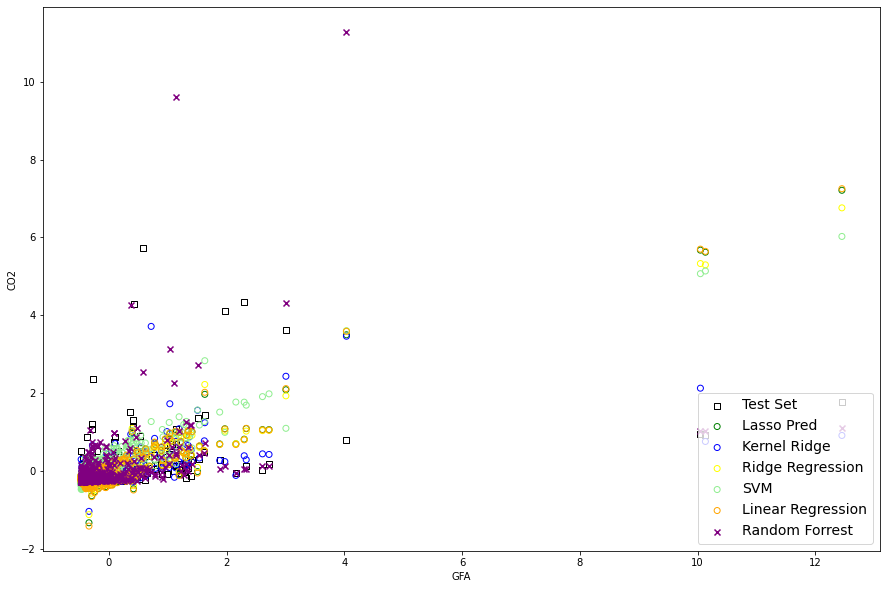

In [159]:


fig = plt.figure(figsize=(15, 10))
plt.scatter(X_test[:, 1], y_test, color="black", marker='s', label="Test Set", facecolors='none')
plt.scatter(X_test[:, 1], Y_pred_lasso[scoreLasso.index(max(scoreLasso))], color="green", marker='o', label="Lasso Pred", facecolors='none')
plt.scatter(X_test[:, 1], Y_pred_kernel_ridge[score_kernel_ridge.index(max(score_kernel_ridge))], facecolors='none', color="blue", marker='o', label="Kernel Ridge")
plt.scatter(X_test[:, 1], Y_pred_reg_ridge[score_reg_ridge.index(max(score_reg_ridge))], color="yellow", facecolors='none', marker='o', label="Ridge Regression")
plt.scatter(X_test[:, 1], Y_pred_svm[scoreLinearSVR.index(max(scoreLinearSVR))], color="lightgreen", marker='o', label="SVM", facecolors='none')
plt.scatter(X_test[:, 1], Y_pred[scoreLinearRegression.index(max(scoreLinearRegression))], color="orange", facecolors='none', marker='o', label="Linear Regression")
plt.scatter(X_test[:, 1], Y_pred_RegressionTree[scoreRegressionTree.index(max(scoreRegressionTree))], color="purple", marker='x', label="Random Forrest")
plt.legend(loc="lower right", fontsize=14)
#plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
#plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
#         (gridSearch.best_params_['gamma'], auc_cv))
#Ajout de la diagonale de 0.0 à 1.1
#plt.plot([0,1], [0, 1])
plt.xlabel("GFA")
plt.ylabel("CO2")

Les phénomènes modelisés par la Forest et par le kernel ridge ont un mouvement qui s'apparente le plus à l'échantillon de test. Logiquement et avec les kernels utilisés pour les SVM, Linear Regression ou encore Ridge Regression se rapproche d'une droite. 

La regression ridge ayant le meilleur score et la meilleure RMSE est en jaune. 


# Y_pred explanation with PrimaryPropertyTypeEnc

Même visualisation maintenant mais avec en abscisse le type de popriété cad une variable categorielle. 

Text(0, 0.5, 'CO2')

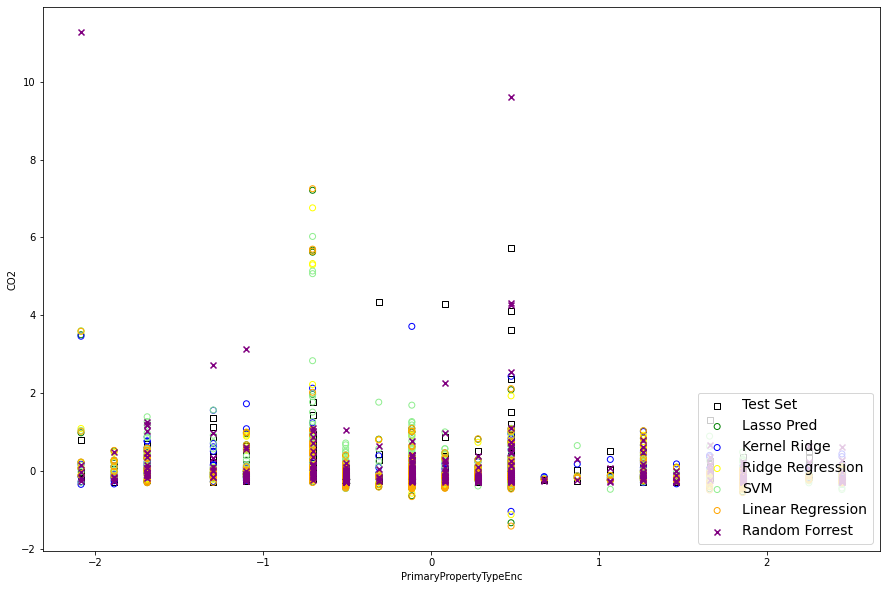

In [160]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(X_test[:, -2], y_test, color="black", marker='s', label="Test Set", facecolors='none')
plt.scatter(X_test[:, -2], Y_pred_lasso[scoreLasso.index(max(scoreLasso))], color="green", marker='o', label="Lasso Pred", facecolors='none')
plt.scatter(X_test[:, -2], Y_pred_kernel_ridge[score_kernel_ridge.index(max(score_kernel_ridge))], color="blue", marker='o',facecolors='none', label="Kernel Ridge")
plt.scatter(X_test[:, -2], Y_pred_reg_ridge[score_reg_ridge.index(max(score_reg_ridge))], color="yellow", marker='o', facecolors='none', label="Ridge Regression")
plt.scatter(X_test[:, -2], Y_pred_svm[scoreLinearSVR.index(max(scoreLinearSVR))], color="lightgreen", marker='o', label="SVM", facecolors='none')
plt.scatter(X_test[:, -2], Y_pred[scoreLinearRegression.index(max(scoreLinearRegression))], color="orange", marker='o', facecolors='none', label="Linear Regression")
plt.scatter(X_test[:, -2], Y_pred_RegressionTree[scoreRegressionTree.index(max(scoreRegressionTree))], color="purple", marker='x', label="Random Forrest")
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("PrimaryPropertyTypeEnc")
plt.ylabel("CO2")

Une fois encore les modèles representant le mieux l'échantillon de test (carrés noirs) sont le kernel ridge et la forrest bien qu'ils aient une RMSE dans la moyenne. 

Le modèle reference pour le C02 Regression Ridge est en jaune sur le graph ci-dessus. 

# Todo Boite à moustache

In [ ]:
green_diamond = dict(markerfacecolor='g', marker='D')
#print(X_test[:, -2])
data = [np.array(Y_pred[scoreLinearRegression.index(max(scoreLinearRegression))]).flatten(), 
        np.array(Y_pred_svm[scoreLinearSVR.index(max(scoreLinearSVR))]).flatten()] 

data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)
#data = [data_1, data_2, data_3, data_4]
#ax1.boxplot(X_test[:, -2], data, flierprops=green_diamond)
print(X_test[:, -2:])
ax.set_xticklabels(['data_1', 'data_2', 
                    'data_3', 'data_4'])
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.show(bp)

In [ ]:
data = Y_pred[scoreLinearRegression.index(max(scoreLinearRegression))]
ax = sns.boxplot(x=X_test[:, -2:], y=data)

# Graph Errors

[0.6547803802766416, 0.511322470758421, 0.5262360240269236]


Text(0.5, 0, 'Coefs Alpha/C')

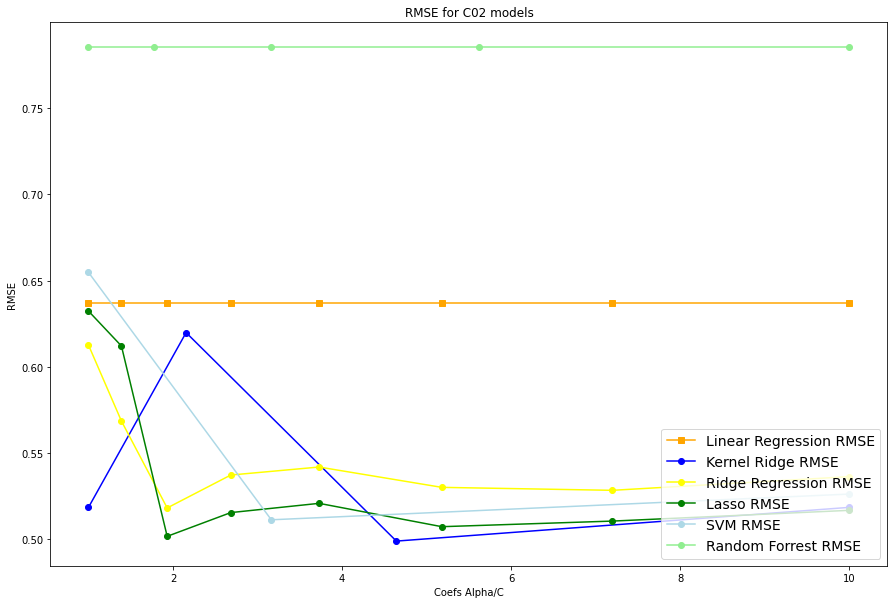

In [161]:
fig = plt.figure(figsize=(15, 10))
#np.logspace(-5, 5, 10),
print(rmseLinearSVR)
plt.plot(np.logspace(0, 1, 8), rmseLinearRegression,  color="orange", marker='s', label="Linear Regression RMSE")
plt.plot(np.logspace(0, 1, 4), rmse_kernel_ridge,  color="blue", marker='o', label="Kernel Ridge RMSE")
plt.plot(np.logspace(0, 1, 8), rmse_reg_ridge,  color="yellow", marker='o', label="Ridge Regression RMSE")
plt.plot(np.logspace(0, 1, 8), rmselasso,  color="green", marker='o', label="Lasso RMSE")
plt.plot(np.logspace(0, 1, 3), rmseLinearSVR,  color="lightblue", marker='o', label="SVM RMSE")
plt.plot(np.logspace(0, 1, 5), (rmseRegressionTree[0], rmseRegressionTree[0], rmseRegressionTree[0], rmseRegressionTree[0], rmseRegressionTree[0]) ,  color="lightgreen", marker='o', label="Random Forrest RMSE")
plt.title("RMSE for C02 models")
plt.legend(loc="lower right", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("Coefs Alpha/C")

En mesurant l'erreur quadtratique des modèles, on observe que le SVM et Lasso font moins bien que la basline en Orange. Les modèles battant la baseline sont le kernel ridge en bleu marine et <b>plus franchement notre modèlé de reference pour le C02 à savoir la Regression Ridge en jaune. </b>

# MAPE FOR CO2

[0.6547803802766416, 0.511322470758421, 0.5262360240269236]


Text(0.5, 0, 'Coefs Alpha/C')

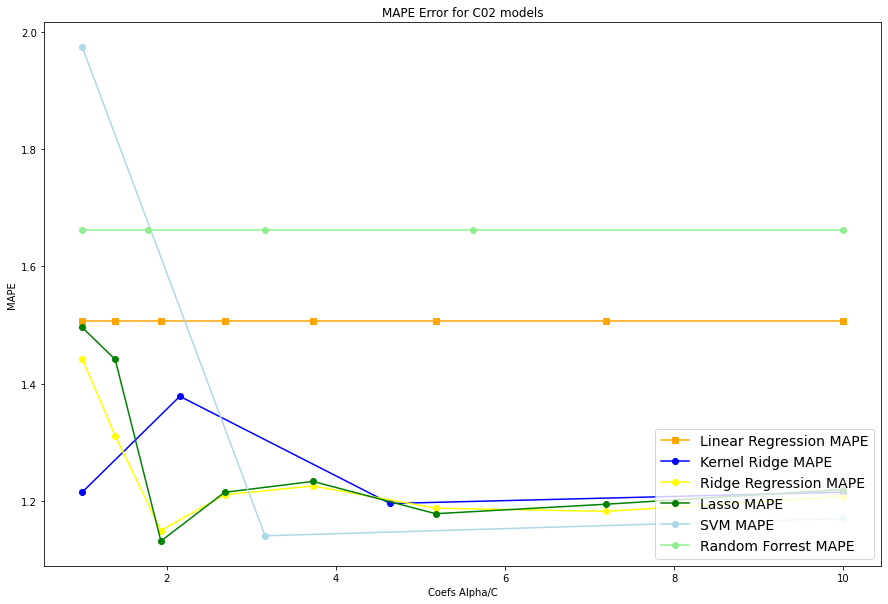

In [162]:
fig = plt.figure(figsize=(15, 10))
#np.logspace(-5, 5, 10),
print(rmseLinearSVR)
plt.plot(np.logspace(0, 1, 8), mapLinearRegression,  color="orange", marker='s', label="Linear Regression MAPE")
plt.plot(np.logspace(0, 1, 4), map_kernel_ridge,  color="blue", marker='o', label="Kernel Ridge MAPE")
plt.plot(np.logspace(0, 1, 8), mapRidge,  color="yellow", marker='o', label="Ridge Regression MAPE")
plt.plot(np.logspace(0, 1, 8), mapLasso,  color="green", marker='o', label="Lasso MAPE")
plt.plot(np.logspace(0, 1, 3), mapLinearSVR,  color="lightblue", marker='o', label="SVM MAPE")
plt.plot(np.logspace(0, 1, 5), (mapRegressionTree[0], mapRegressionTree[0], mapRegressionTree[0], mapRegressionTree[0], mapRegressionTree[0]) ,  color="lightgreen", marker='o', label="Random Forrest MAPE")
plt.title("MAPE Error for C02 models")
plt.legend(loc="lower right", fontsize=14)
plt.ylabel("MAPE")
plt.xlabel("Coefs Alpha/C")

si on observe la performance des modèles via Mean absolute percentage error, le Lasso est le plus performant devant <b>la SVM et enfin la Regression Ridge qui fait un peu mieux que la baseline en Orange. </b>

# Selon les 2 mesures de performances ainsi que par le score la regression ridge semble la plus performante pour predire les emissions de CO2 des batiments à partir de variables declaratives uniquement. 

# Modeles pour prédire TotalGHGEmissions par batiment avec des variables declaratives. 

Nous allons maintenant passé à la modelisation TotalGHGEmissions. Nous allons utilisé la même approche que pour la modelisation du CO2. 

# Preprocessing, Datasplit and baseline

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a 

(3366, 38)
      YearBuilt  PropertyGFATotal  LocationEnc  LargestPropertyUseTypeEnc  \
3340       1927             88434            0                         13   
3341       1996            103566            0                         13   
3342       1969            956110            0                         13   
3343       1926             61320            0                         13   
3344       1980            175580            0                         13   
...         ...               ...          ...                        ...   
6711       1990             12294            0                         24   
6712       2004             16000            0                         31   
6713       1974             13157            0                         31   
6714       1989             14101            0                         31   
6715       1938             18258            0                         31   

      PropertyGFAParkingEnc  NumberofFloorsEnc  NumberofBuilding

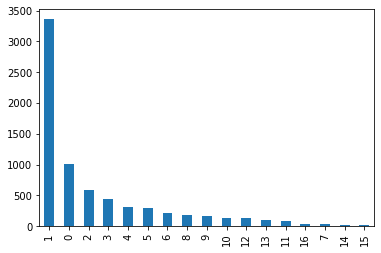

In [179]:
#Label Encoder + Std 
columnsEncodedToKeep = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc']
filteredDF3 = filteredDF

for column in filteredDF.columns:
    #print(column, str(filteredDF[column].dtype))
    if str(filteredDF[column].dtype) == "object" and column in ["PrimaryPropertyType", "City", "State", "Neighborhood"]: #"Location", "Neighborhood", "PropertyGFAParking", 
        a = filteredDF[column].value_counts().to_frame()
        a = a[a[column] > 1]
        #print(column, list(a.index.values))
        
        #filteredDF2 = filteredDF2[filteredDF2[column].isin(list(a.index.values))]
        filteredDF3[column].loc[filteredDF3[column].str.len() > 20] = "other"
        #filteredDF2[column].loc[filteredDF2[column].str.isnumeric()] = "other"
        
        filteredDF3[column] = filteredDF3[column].str.strip()
        filteredDF3[column] = filteredDF3[column].str.lower()
        filteredDF3[column] = filteredDF3[column].str.replace('"', '')
        
filteredDF3['TotalGHGEmissions'] = filteredDF3['TotalGHGEmissions'].replace(np.nan, -1000)
filteredDF3 = filteredDF3[filteredDF3['TotalGHGEmissions'] >= 0]

for column in ["Neighborhood", "PrimaryPropertyType", "BuildingType", "LargestPropertyUseType","Location", "PropertyGFAParking", "NumberofFloors", "NumberofBuildings"]:
    newCol = column+"Enc"
    filteredDF3[newCol] = encoder.fit_transform(filteredDF3[column].values)
    filteredDF3[newCol].value_counts().plot(kind="bar")



print(filteredDF3.shape)

#y = filteredDF2['GHGEmissions(MetricTonsCO2e)'].values.reshape(-1, 1)
#y_std = StandardScaler().fit_transform(filteredDF2['GHGEmissionsIntensity(kgCO2e/ft2)'].values.reshape(-1, 1))
y_std_ghge = StandardScaler().fit_transform(filteredDF3['TotalGHGEmissions'].values.reshape(-1, 1))
print(filteredDF3.filter(items=columnsEncodedToKeep))
#GHGEmissionsIntensity(kgCO2e/ft2)

stdScaler = StandardScaler()
X_ghge = filteredDF3.filter(items=columnsEncodedToKeep)

X_std = stdScaler.fit_transform(X_ghge.values)
X_train_ghge, X_test_ghge, y_train_ghge, y_test_ghge = model_selection.train_test_split(X_std, y_std_ghge, train_size=0.8)

Après traitement et application du mask, nous travaillons sur un échantillon de 3366 objets. 

# Linear Regression and Baseline for GHGE

In [180]:
lrCV = linear_model.LinearRegression()
params = {"fit_intercept": ["True", "False"], "normalize": ["True", "False"] } 
rmseLinearRegressionGHGE = []
mapLinearGHGE =  []

Y_pred_GHGE = []
for cv in range(2, 10):
    lr_gs_GHGE = GridSearchCV(lrCV, params, cv=cv)
    #print(lrCV.get_params().keys())
    lr_gs_GHGE.fit(X_train_ghge, y_train_ghge)
    print(cv, lr_gs_GHGE.best_params_)
    print(cv, lr_gs_GHGE.best_score_)
    Y_pred_GHGE.append(lr_gs.predict(X_test_ghge))
    mape = np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, lr_gs.predict(X_test_ghge)))
    rmse = np.sqrt(metrics.mean_squared_error(y_test_ghge, lr_gs.predict(X_test_ghge)))
    mapLinearGHGE.append(mape)
    rmseLinearRegressionGHGE.append(rmse)
    print(cv, lr_gs_GHGE.best_score_, rmse, mape)

2 {'fit_intercept': 'True', 'normalize': 'True'}
2 -0.08017151268410783
2 -0.08017151268410783 0.36257321129247455 1.8937426931300743
3 {'fit_intercept': 'True', 'normalize': 'True'}
3 0.2508586644073324
3 0.2508586644073324 0.36257321129247455 1.8937426931300743
4 {'fit_intercept': 'True', 'normalize': 'True'}
4 0.047559786686304784
4 0.047559786686304784 0.36257321129247455 1.8937426931300743
5 {'fit_intercept': 'True', 'normalize': 'True'}
5 0.06758675712534779
5 0.06758675712534779 0.36257321129247455 1.8937426931300743
6 {'fit_intercept': 'True', 'normalize': 'True'}
6 0.0415437614529409
6 0.0415437614529409 0.36257321129247455 1.8937426931300743
7 {'fit_intercept': 'True', 'normalize': 'True'}
7 -0.002426730905249078
7 -0.002426730905249078 0.36257321129247455 1.8937426931300743
8 {'fit_intercept': 'True', 'normalize': 'True'}
8 0.1277571000826946
8 0.1277571000826946 0.36257321129247455 1.8937426931300743
9 {'fit_intercept': 'True', 'normalize': 'True'}
9 0.05218230116055286
9 0

In [165]:
eli5.show_weights(lr_gs_GHGE.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

Weight?,Feature
+0.725,PropertyGFATotal
+0.081,NumberofBuildingsEnc
+0.008,<BIAS>
+0.002,LargestPropertyUseTypeEnc
-0.019,NeighborhoodEnc
-0.025,PrimaryPropertyTypeEnc
-0.029,YearBuilt
-0.032,BuildingTypeEnc
-0.105,PropertyGFAParkingEnc
-0.121,NumberofFloorsEnc


Pour la regression linéaire, notre baseline, nous observons une mape à 16 et une RMSE à 0.73. L'observation de la ponderation des variables fait une nouvelle fois resortir la surface en 1 puis le nombre de batiment. Le type de batiment n'a qu'une faible importance ici. 

# Regression Ridge for GHGE

In [182]:
# paramètre de regularisation 
n_alphas = 100
alphas = np.logspace(-5, 5, n_alphas)
Y_pred_reg_ridge_GHGE = []
rmse_reg_ridge_GHGE = []
mapRidgeGHGE  = []
score_reg_ridge_GHGE = []
params = {"alpha": np.logspace(-5, 5, n_alphas), "normalize": ["True", "False"]}

now = time.time()

for cv in range(2, 10):
    ridgeCV_GHGE = GridSearchCV(linear_model.Ridge(), params, cv=cv)
#print(linear_model.Ridge().get_params())
    ridgeCV_GHGE.fit(X_train_ghge, y_train_ghge)
    #print(cv, ridgeCV.best_score_)
    score_reg_ridge_GHGE.append(ridgeCV_GHGE.best_score_)
    Y_pred_reg_ridge_GHGE.append(ridgeCV_GHGE.predict(X_test_ghge))
    mapRidgeGHGE.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, Y_pred_reg_ridge_GHGE[-1])))
    rmse_reg_ridge_GHGE.append(np.sqrt(metrics.mean_squared_error(y_test_ghge, Y_pred_reg_ridge_GHGE[-1])))
    print(cv, ridgeCV_GHGE.best_score_, ridgeCV_GHGE.best_params_, rmse_reg_ridge_GHGE[-1], mapRidgeGHGE[-1])

later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 0.10577675895088667 {'alpha': 2.2570197196339215, 'normalize': 'True'} 0.3400928694667134 1.5755761346689865
3 0.25984122281235533 {'alpha': 0.13848863713938717, 'normalize': 'True'} 0.3701715360162993 1.9895298885268098
4 0.15716161288521746 {'alpha': 1.7886495290574351, 'normalize': 'True'} 0.3395182885117609 1.6364916414116741
5 0.2003932980233447 {'alpha': 1.1233240329780265, 'normalize': 'True'} 0.34239475593967333 1.7493354848320797
6 0.2231012660664536 {'alpha': 1.1233240329780265, 'normalize': 'True'} 0.34239475593967333 1.7493354848320797
7 0.15355360953249925 {'alpha': 1.7886495290574351, 'normalize': 'True'} 0.3395182885117609 1.6364916414116741
8 0.23203542561985568 {'alpha': 0.8902150854450392, 'normalize': 'True'} 0.3454551326305533 1.7978606241683759
9 0.20146904221325457 {'alpha': 1.1233240329780265, 'normalize': 'True'} 0.34239475593967333 1.7493354848320797
Calculation Time 11 seconds


In [183]:
eli5.show_weights(ridgeCV_GHGE.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

Weight?,Feature
+0.225,PropertyGFATotal
+0.154,NumberofBuildingsEnc
+0.028,NumberofFloorsEnc
+0.009,<BIAS>
+0.007,BuildingTypeEnc
-0.007,YearBuilt
-0.008,PropertyGFAParkingEnc
-0.008,LargestPropertyUseTypeEnc
-0.016,NeighborhoodEnc
-0.019,PrimaryPropertyTypeEnc


Pour la regression ridge, le poids des variables est plus homogène mais la RMSE tout comme la mape demeurrent très proche de la baseline. 

# Lasso for GHGE

In [200]:
lasso = linear_model.Lasso(max_iter=10000)
params = {"alpha": np.logspace(-5, 5, 100), "normalize": ["True", "False"]}
Y_pred_lasso_GHGE = []
rmselasso_GHGE  = []
mapLassoGHGE =[]
scoreLasso_GHGE  = []

now = time.time()

for cv in range(2, 10):
    lassoGS_GHGE = GridSearchCV(lasso, params, cv=cv)
    lassoGS_GHGE.fit(X_train_ghge, y_train_ghge)
    scoreLasso_GHGE.append(lassoGS_GHGE.best_score_)
    Y_pred_lasso_GHGE.append(lassoGS_GHGE.predict(X_test_ghge))
    rmselasso_GHGE.append(np.sqrt(metrics.mean_squared_error(y_test_ghge, Y_pred_lasso_GHGE[-1])))
    mapLassoGHGE.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, Y_pred_lasso_GHGE[-1])))

    print(cv, lassoGS_GHGE.best_score_,lassoGS_GHGE.best_params_,  rmselasso_GHGE[-1], mapLassoGHGE[-1])

later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 0.08378871493964113 {'alpha': 0.013530477745798075, 'normalize': 'True'} 0.38731261049058463 1.0487054026650589
3 0.26601516359443217 {'alpha': 0.0007066183616478003, 'normalize': 'True'} 0.35649774641979215 1.9718322986305847
4 0.19501199947740527 {'alpha': 0.005838168531096668, 'normalize': 'True'} 0.3407958380265709 1.3736144348669603
5 0.24669709901712303 {'alpha': 0.004691018295119662, 'normalize': 'True'} 0.3287703329033527 1.5102588466352027
6 0.2640551002096024 {'alpha': 0.004658722333865206, 'normalize': 'True'} 0.3285013405561102 1.5145687967373265


KeyboardInterrupt: 

In [186]:
eli5.show_weights(lassoGS_GHGE.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

Weight?,Feature
+0.319,PropertyGFATotal
+0.055,NumberofBuildingsEnc
+0.006,<BIAS>


Encore une fois et comme pour le CO2, le Lasso fait bien son travail et elimine pratiquement toutes les variables sauf la surface et le nombre de batiment. En revanche, d'un point de vue de la mesure des erreurs produites, le lasso est très proche de la baselien sans pour autant faire mieux qu'elle. 

# Kernel Ridge for GHGE

In [187]:
params = {"gamma": np.logspace(-5, 5, 10), 
          "alpha": np.logspace(-5, 5, 10), 
          "kernel": ["rbf", "linear"]}
rmse_kernel_ridge_GHGE = []
score_kernel_ridge_GHGE = []
Y_pred_kernel_ridge_GHGE = []
now = time.time()
mapKernelRidgeGHGE = []
for cv in range(2, 6):
    kernelRidgeCV_GHGE = model_selection.GridSearchCV(KernelRidge(), params, cv=cv, scoring="neg_mean_squared_error")
    kernelRidgeCV_GHGE.fit(X_train_ghge, y_train_ghge)
    Y_pred_kernel_ridge_GHGE.append(kernelRidgeCV_GHGE.predict(X_test_ghge))
    score_kernel_ridge_GHGE.append(kernelRidgeCV_GHGE.best_score_)
    rmse_kernel_ridge_GHGE.append(np.sqrt(metrics.mean_squared_error(y_test_ghge, Y_pred_kernel_ridge_GHGE[-1])))
    mapKernelRidgeGHGE.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, Y_pred_kernel_ridge_GHGE[-1])))

    print(cv, kernelRidgeCV_GHGE.best_score_, kernelRidgeCV_GHGE.best_params_ , rmse_kernel_ridge_GHGE[-1], map_kernel_ridge[-1])
    
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

2 -0.7910817218590331 {'alpha': 0.0016681005372000592, 'gamma': 0.0016681005372000592, 'kernel': 'rbf'} 0.3702948059000159 1.214716294582151
3 -0.7315858432431096 {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'} 0.33619808450295685 1.214716294582151
4 -0.6169577519854704 {'alpha': 0.0016681005372000592, 'gamma': 0.0016681005372000592, 'kernel': 'rbf'} 0.3702948059000159 1.214716294582151
5 -0.6674125265985866 {'alpha': 0.0016681005372000592, 'gamma': 0.0016681005372000592, 'kernel': 'rbf'} 0.3702948059000159 1.214716294582151
Calculation Time 439 seconds


Ici le kernel ridge est assez lent (près de 5 min) mais ses performances d'un point de vue de la RMSE ou de la MAPE sont bien meilleurs que la baseline. 

- RMSE : 0.64
- MAPE : 1.67

Les performances en font le modèle de reference pour le moment concernant la prediction de GHGE. 

# SVM for GHGE

In [190]:
SVR = svm.LinearSVR(max_iter=100000)
parameters = {"C": np.logspace(-5, 5, 10)}#, "kernel": ["rbf"]}
rmseLinearSVR_GHGE = []
mapLinearSVR_GHGE = []
scoreLinearSVR_GHGE = []
Y_pred_svm_GHGE = []
now = time.time()


for cv in range(2, 6):
    lr_svm_GHGE = GridSearchCV(SVR, parameters, cv=cv)
    lr_svm_GHGE.fit(MinMaxScaler().fit_transform(X_train_ghge), y_train_ghge.ravel())
    Y_pred_svm_GHGE.append(lr_svm_GHGE.predict(MinMaxScaler().fit_transform(X_test_ghge)))
    scoreLinearSVR_GHGE.append(lr_svm_GHGE.best_score_)
    rmseLinearSVR_GHGE.append(np.sqrt(metrics.mean_squared_error(y_test_ghge, Y_pred_svm_GHGE[-1])))
    
    mapLinearSVR_GHGE.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, Y_pred_svm_GHGE[-1])))
    print(cv, lr_svm_GHGE.best_score_, lr_svm_GHGE.best_params_ , rmseLinearSVR_GHGE[-1], mapLinearSVR[-1])
    
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")
eli5.show_weights(lr_svm_GHGE.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

2 0.26795935085620315 {'C': 100000.0} 1.8212557752175937 1.1698872145507038


/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

3 0.21340757295261348 {'C': 599.4842503189421} 1.2030001265213444 1.1698872145507038


/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

4 0.2375464906262358 {'C': 599.4842503189421} 1.2002131023642937 1.1698872145507038


/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

5 0.24445381254632367 {'C': 599.4842503189421} 1.2055654780117275 1.1698872145507038
Calculation Time 283 seconds


/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Weight?,Feature
+12.351,PropertyGFATotal
+0.282,NumberofBuildingsEnc
+0.095,BuildingTypeEnc
+0.066,NumberofFloorsEnc
+0.060,LargestPropertyUseTypeEnc
-0.020,NeighborhoodEnc
-0.027,PrimaryPropertyTypeEnc
-0.043,YearBuilt
-0.083,PropertyGFAParkingEnc
-0.250,<BIAS>


In [191]:
eli5.show_weights(lr_svm_GHGE.best_estimator_, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

Weight?,Feature
+12.351,PropertyGFATotal
+0.282,NumberofBuildingsEnc
+0.095,BuildingTypeEnc
+0.066,NumberofFloorsEnc
+0.060,LargestPropertyUseTypeEnc
-0.020,NeighborhoodEnc
-0.027,PrimaryPropertyTypeEnc
-0.043,YearBuilt
-0.083,PropertyGFAParkingEnc
-0.250,<BIAS>


Ici la SVM offre des performances similaires légèrement en baisse par rapport au Kernel Ridge tout en faisant bien mieux que la basline <b>mais avec un temps de calcul beaucoup plus faible (X5)</b>

# Regression TREE GHGE

In [193]:
#TODO ajouter sur le graph 
#TODO scoring mean_absolute_percentage_error
#TODO feature importance 
#import eli5
#eli5.show_weights(model, feature_names = X.columns.tolist())
Y_pred_RegressionTreeGHGE = []
rmseRegressionTreeGHGE = []
scoreRegressionTreeGHGE = []
mapRegressionTreeGHGE = []
now = time.time()
RegressionTreeGHGE = DecisionTreeRegressor()
RegressionTreeGHGE.fit(X_train_ghge, y_train_ghge.ravel())
Y_pred_RegressionTreeGHGE.append(RegressionTreeGHGE.predict(X_test_ghge))
rmseRegressionTreeGHGE.append(np.sqrt(metrics.mean_squared_error(y_test_ghge.ravel(), Y_pred_RegressionTreeGHGE[-1])))
mapRegressionTreeGHGE.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, Y_pred_RegressionTreeGHGE[-1])))
scoreRegressionTreeGHGE.append(RegressionTreeGHGE.score)
print(RegressionTreeGHGE.score, rmseRegressionTreeGHGE, mapRegressionTreeGHGE)


#Calculation time
later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")
eli5.show_weights(RegressionTreeGHGE, feature_names = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc'])

<bound method RegressorMixin.score of DecisionTreeRegressor()> [0.4230479915312954] [2.2488499605207064]
Calculation Time 0 seconds


Weight,Feature
0.5001,PropertyGFATotal
0.2016,NumberofBuildingsEnc
0.1725,BuildingTypeEnc
0.0484,PrimaryPropertyTypeEnc
0.0400,YearBuilt
0.0166,LargestPropertyUseTypeEnc
0.0114,NumberofFloorsEnc
0.0049,PropertyGFAParkingEnc
0.0045,NeighborhoodEnc
0,LocationEnc


Les performances d'un arbre pour ce problème sont assez faible et sont bien inferieur à la baseline quelquesoit la methode de mesure des erreurs. 

# RMSE for GHGE

[0.6547803802766416, 0.511322470758421, 0.5262360240269236]


Text(0.5, 0, 'Coefs Alpha/C')

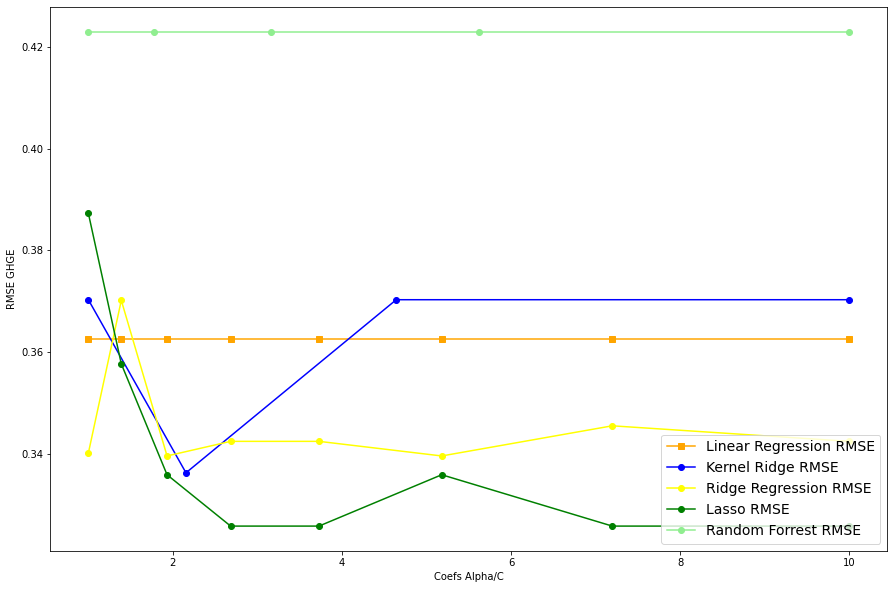

In [195]:
fig = plt.figure(figsize=(15, 10))
#np.logspace(-5, 5, 10),
print(rmseLinearSVR)
plt.plot(np.logspace(0, 1, 8), rmseLinearRegressionGHGE,  color="orange", marker='s', label="Linear Regression RMSE")
plt.plot(np.logspace(0, 1, 4), rmse_kernel_ridge_GHGE,  color="blue", marker='o', label="Kernel Ridge RMSE")
plt.plot(np.logspace(0, 1, 8), rmse_reg_ridge_GHGE,  color="yellow", marker='o', label="Ridge Regression RMSE")
plt.plot(np.logspace(0, 1, 8), rmselasso_GHGE,  color="green", marker='o', label="Lasso RMSE")
#plt.plot(np.logspace(0, 1, 4), rmseLinearSVR_GHGE,  color="lightblue", marker='o', label="SVM RMSE")
plt.plot(np.logspace(0, 1, 5), (rmseRegressionTreeGHGE[0], rmseRegressionTreeGHGE[0], rmseRegressionTreeGHGE[0], rmseRegressionTreeGHGE[0], rmseRegressionTreeGHGE[0]) ,  color="lightgreen", marker='o', label="Random Forrest RMSE")

plt.legend(loc="lower right", fontsize=14)
plt.ylabel("RMSE GHGE")
plt.xlabel("Coefs Alpha/C")

On observe ici aisement que les performances du kernel ridge sont bien meilleurs que les autres modèles si on utilise la mesure des erreurs quadratiques. La majorité des modèles font entre proche ou beaucoup moins bien que la baseline. 

# MAPE for GHGE

[0.6547803802766416, 0.511322470758421, 0.5262360240269236]


Text(0.5, 0, 'Coefs Alpha/C')

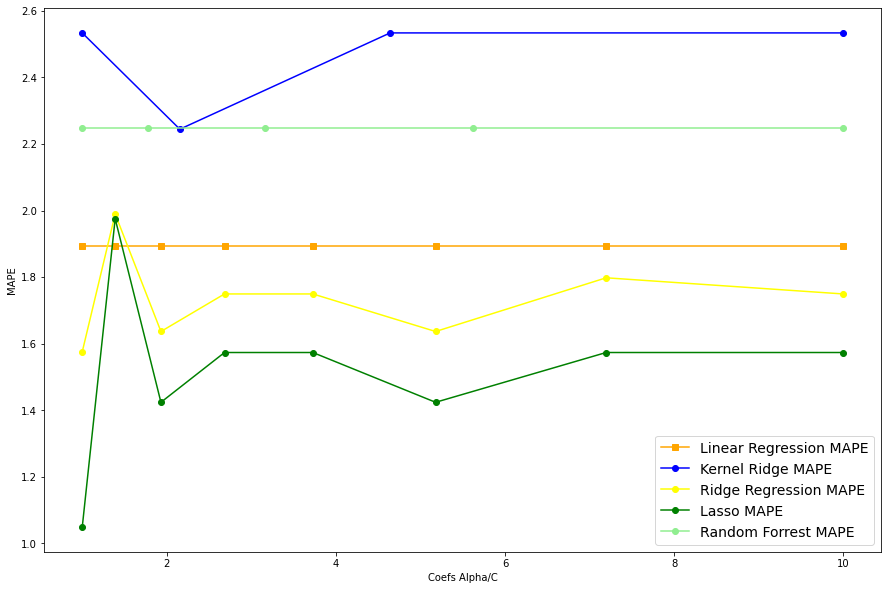

In [197]:
fig = plt.figure(figsize=(15, 10))
#np.logspace(-5, 5, 10),
print(rmseLinearSVR)
plt.plot(np.logspace(0, 1, 8), mapLinearGHGE,  color="orange", marker='s', label="Linear Regression MAPE")
plt.plot(np.logspace(0, 1, 4), mapKernelRidgeGHGE,  color="blue", marker='o', label="Kernel Ridge MAPE")
plt.plot(np.logspace(0, 1, 8), mapRidgeGHGE,  color="yellow", marker='o', label="Ridge Regression MAPE")
plt.plot(np.logspace(0, 1, 8), mapLassoGHGE,  color="green", marker='o', label="Lasso MAPE")
#plt.plot(np.logspace(0, 1, 4), mapLinearSVR_GHGE,  color="lightblue", marker='o', label="SVM MAPE")
plt.plot(np.logspace(0, 1, 5), (mapRegressionTreeGHGE[0], mapRegressionTreeGHGE[0], mapRegressionTreeGHGE[0], mapRegressionTreeGHGE[0], mapRegressionTreeGHGE[0]) ,  color="lightgreen", marker='o', label="Random Forrest MAPE")

plt.legend(loc="lower right", fontsize=14)
plt.ylabel("MAPE")
plt.xlabel("Coefs Alpha/C")

Encore une fois le kernel ridge est selon cette mesure d'erreur MAPE, le modèle le plus performants de tous et d'assez loin. 

## Le kernel ridge est donc le modèle de reference pour la prediction de TotalGHGEmissions. 


# Y_pred with GFA

Text(0, 0.5, 'GHGE')

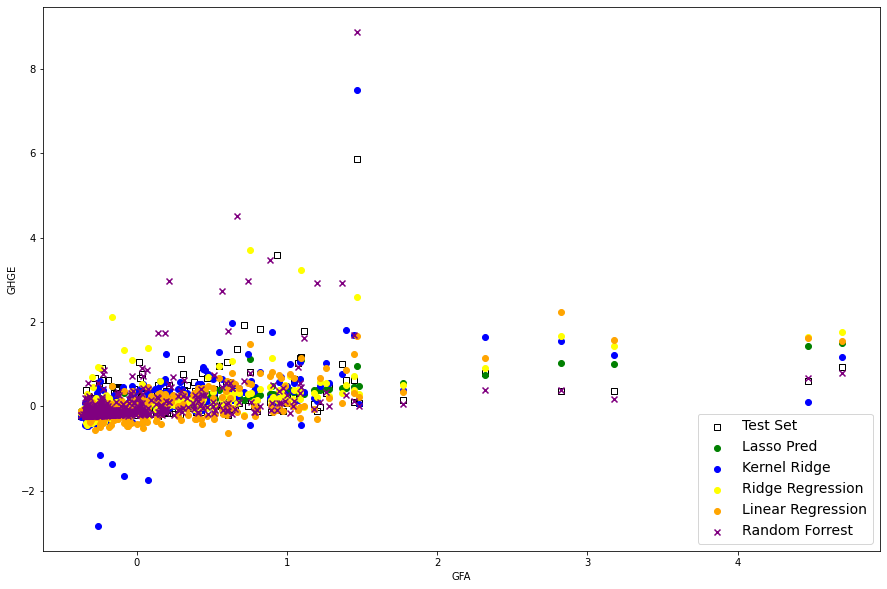

In [199]:
#A ajouter H2O pour aller à l'essentiel
#print(X_test[:, 1])
fig = plt.figure(figsize=(15, 10))
plt.scatter(X_test_ghge[:, 1], y_test_ghge, color="black", marker='s', label="Test Set", facecolors='none')
plt.scatter(X_test_ghge[:, 1], Y_pred_lasso_GHGE[scoreLasso_GHGE.index(max(scoreLasso_GHGE))], color="green", marker='o', label="Lasso Pred")
plt.scatter(X_test_ghge[:, 1], Y_pred_kernel_ridge_GHGE[score_kernel_ridge_GHGE.index(max(score_kernel_ridge_GHGE))], color="blue", marker='o', label="Kernel Ridge")
plt.scatter(X_test_ghge[:, 1], Y_pred_reg_ridge_GHGE[score_reg_ridge_GHGE.index(max(score_reg_ridge_GHGE))], color="yellow", marker='o', label="Ridge Regression")
#plt.scatter(X_test_ghge[:, 1], Y_pred_svm_GHGE[scoreLinearSVR_GHGE.index(max(scoreLinearSVR_GHGE))], color="lightgreen", marker='o', label="SVM", facecolors='none')
plt.scatter(X_test_ghge[:, 1], Y_pred_GHGE[scoreLinearRegression.index(max(scoreLinearRegression))], color="orange", marker='o', label="Linear Regression")
plt.scatter(X_test_ghge[:, 1], Y_pred_RegressionTreeGHGE[scoreRegressionTreeGHGE.index(max(scoreRegressionTreeGHGE))], color="purple", marker='x', label="Random Forrest")
plt.legend(loc="lower right", fontsize=14)
#plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
#plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
#         (gridSearch.best_params_['gamma'], auc_cv))
#Ajout de la diagonale de 0.0 à 1.1
#plt.plot([0,1], [0, 1])
plt.xlabel("GFA")
plt.ylabel("GHGE")

# En conclusion, il est absolument possible de prédire CO2 et TotalGHGEmissions avec comme modèle de reference la regression ridge ou un kernel ridge entrainés avec des variables declaratives et donc sans mesure dans les batiments. 

# En revanche, la performance des modèles de reference reste modeste notamment si on observe la Mape (exprimée en % et) > 1. 

# On peut donc utiliser ces données comme estimation mais une mesure précise reste indispensable. 

# Optimisation for Lasso  

In [214]:
#Label Encoder + Std 
columnsEncodedToKeep = ['YearBuilt', 'PropertyGFATotal',  "LocationEnc", "LargestPropertyUseTypeEnc", "PropertyGFAParkingEnc", "NumberofFloorsEnc", "NumberofBuildingsEnc", 'NeighborhoodEnc', 'PrimaryPropertyTypeEnc', 'BuildingTypeEnc']
filteredDF3 = filteredDF

for column in filteredDF.columns:
    #print(column, str(filteredDF[column].dtype))
    if str(filteredDF[column].dtype) == "object" and column in ["PrimaryPropertyType", "City", "State", "Neighborhood"]: #"Location", "Neighborhood", "PropertyGFAParking", 
        a = filteredDF[column].value_counts().to_frame()
        a = a[a[column] > 1]
        #print(column, list(a.index.values))
        
        #filteredDF2 = filteredDF2[filteredDF2[column].isin(list(a.index.values))]
        filteredDF3[column].loc[filteredDF3[column].str.len() > 20] = "other"
        #filteredDF2[column].loc[filteredDF2[column].str.isnumeric()] = "other"
        
        filteredDF3[column] = filteredDF3[column].str.strip()
        filteredDF3[column] = filteredDF3[column].str.lower()
        filteredDF3[column] = filteredDF3[column].str.replace('"', '')
        
        
for column in ["Neighborhood", "PrimaryPropertyType", "BuildingType", "LargestPropertyUseType","Location", "PropertyGFAParking", "NumberofFloors", "NumberofBuildings"]:
    newCol = column+"Enc"
    filteredDF3[newCol] = encoder.fit_transform(filteredDF3[column].values)
        

filteredDF3['TotalGHGEmissions'] = filteredDF3['TotalGHGEmissions'].replace(np.nan, -1000)
filteredDF3 = filteredDF3[filteredDF3['TotalGHGEmissions'] >= 0]
filteredDF3 = filteredDF3[filteredDF3['NumberofBuildingsEnc'] >= 1]
filteredDF3 = filteredDF3[filteredDF3['BuildingTypeEnc'] >= 1]


#y = filteredDF2['GHGEmissions(MetricTonsCO2e)'].values.reshape(-1, 1)
#y_std = StandardScaler().fit_transform(filteredDF2['GHGEmissionsIntensity(kgCO2e/ft2)'].values.reshape(-1, 1))
stdScaler = StandardScaler()
y_std_ghge = StandardScaler().fit_transform(filteredDF3['TotalGHGEmissions'].values.reshape(-1, 1))
#y_std_ghge = MinMaxScaler().fit_transform(filteredDF3['TotalGHGEmissions'].values.reshape(-1, 1))
#y_std_ghge = MinMaxScaler().fit_transform(y_std_ghge)





X_ghge = filteredDF3.filter(items=columnsEncodedToKeep)
X_std = stdScaler.fit_transform(X_ghge.values)
#X_std = minMaxScaler.fit_transform(X_std)
#X_std = minMaxScaler.fit_transform(X_ghge.values)
X_train_ghge, X_test_ghge, y_train_ghge, y_test_ghge = model_selection.train_test_split(X_std, y_std_ghge, train_size=0.8)



#update Baseline
lrCV = linear_model.LinearRegression()
params = {"fit_intercept": ["True", "False"], "normalize": ["True", "False"] } 
rmseLinearRegressionGHGE = []
mapLinearGHGE =  []

Y_pred_GHGE = []
for cv in range(2, 10):
    lr_gs_GHGE = GridSearchCV(lrCV, params, cv=cv)
    #print(lrCV.get_params().keys())
    lr_gs_GHGE.fit(X_train_ghge, y_train_ghge)
    print(cv, lr_gs_GHGE.best_params_)
    print(cv, lr_gs_GHGE.best_score_)
    Y_pred_GHGE.append(lr_gs.predict(X_test_ghge))
    mape = np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, lr_gs.predict(X_test_ghge)))
    rmse = np.sqrt(metrics.mean_squared_error(y_test_ghge, lr_gs.predict(X_test_ghge)))
    mapLinearGHGE.append(mape)
    rmseLinearRegressionGHGE.append(rmse)
    print(cv, lr_gs_GHGE.best_score_, rmse, mape)




#update Lasso
lasso = linear_model.Lasso(max_iter=10000)
params = {"alpha": np.logspace(-5, 5, 1000), "normalize": ["True", "False"]}
Y_pred_lasso_GHGE = []
rmselasso_GHGE  = []
mapLassoGHGE =[]
scoreLasso_GHGE  = []

now = time.time()

for cv in range(2, 10):
    lassoGS_GHGE = GridSearchCV(lasso, params, cv=cv)
    lassoGS_GHGE.fit(X_train_ghge, y_train_ghge)
    scoreLasso_GHGE.append(lassoGS_GHGE.best_score_)
    Y_pred_lasso_GHGE.append(lassoGS_GHGE.predict(X_test_ghge))
    rmselasso_GHGE.append(np.sqrt(metrics.mean_squared_error(y_test_ghge, Y_pred_lasso_GHGE[-1])))
    mapLassoGHGE.append(np.sqrt(metrics.mean_absolute_percentage_error(y_test_ghge, Y_pred_lasso_GHGE[-1])))

    print(cv, lassoGS_GHGE.best_score_,lassoGS_GHGE.best_params_,  rmselasso_GHGE[-1], mapLassoGHGE[-1])

later = time.time()
difference = int(later - now)
print("Calculation Time", difference, "seconds")

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a 

2 {'fit_intercept': 'True', 'normalize': 'True'}
2 0.29502429191914353
2 0.29502429191914353 0.8211775203840459 1.449972089186559
3 {'fit_intercept': 'True', 'normalize': 'True'}
3 0.10249565830351826
3 0.10249565830351826 0.8211775203840459 1.449972089186559
4 {'fit_intercept': 'True', 'normalize': 'True'}
4 0.10370885227298454
4 0.10370885227298454 0.8211775203840459 1.449972089186559
5 {'fit_intercept': 'True', 'normalize': 'True'}
5 0.12362340743143874
5 0.12362340743143874 0.8211775203840459 1.449972089186559
6 {'fit_intercept': 'True', 'normalize': 'True'}
6 0.010995135423725913
6 0.010995135423725913 0.8211775203840459 1.449972089186559
7 {'fit_intercept': 'True', 'normalize': 'True'}
7 0.08249638301887983
7 0.08249638301887983 0.8211775203840459 1.449972089186559
8 {'fit_intercept': 'True', 'normalize': 'True'}
8 0.07114041358126066
8 0.07114041358126066 0.8211775203840459 1.449972089186559
9 {'fit_intercept': 'True', 'normalize': 'True'}
9 0.08151044063638532
9 0.0815104406363